# CUSTOMER REVIEWS SENTIMENTAL ANALYSIS

## 1. Problem Statement
The goal of this project is to learn how to perform sentiment analysis in Python. We will be using Natural Language Processing (NLP) technique to discover negative customer ratings evaluations based on data collected from the hotel reviews.

The dataset includes consumer ratings and textual feedback about their hotel experiences. We will be using NLP that involves extracting emotions from raw texts. This is commonly used on social media posts and customer reviews to automatically determine whether some individuals are favourable or negative, as well as why. Utilizing only raw textual review data, we will attempt to forecast information.

## 2. Data Loading

First step is we load the data. I have uploaded the dataset on my google drive. 

### 2.1 Importing Libraries

In [1]:
import seaborn as sns
import matplotlib
import numpy as np
import plotly.express as px
import nltk
import nltk.corpus as corpus;
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
import string
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import eli5 #for permutation importance
from eli5.sklearn import PermutationImportance
from sklearn.metrics import average_precision_score, precision_recall_curve
from inspect import signature
from nltk.corpus import stopwords
# nltk.download('vader_lexicon')
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from ast import literal_eval
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### 2.2 Reading data

In [2]:
rev_df = pd.read_csv("/Users/ankitaindi/Documents/Hotel_Reviews.csv")
rev_df=rev_df[:70000]

### 2.3 Data Overview

In [3]:
rev_df.head(2)

Hotel_Address  \
0   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   
1   s Gravesandestraat 55 Oost 1092 AA Amsterdam ...   

   Additional_Number_of_Scoring Review_Date  Average_Score   Hotel_Name  \
0                           194    8/3/2017            7.7  Hotel Arena   
1                           194    8/3/2017            7.7  Hotel Arena   

  Reviewer_Nationality                                    Negative_Review  \
0              Russia    I am so angry that i made this post available...   
1             Ireland                                         No Negative   

   Review_Total_Negative_Word_Counts  Total_Number_of_Reviews  \
0                                397                     1403   
1                                  0                     1403   

                                     Positive_Review  \
0   Only the park outside of the hotel was beauti...   
1   No real complaints the hotel was great great ...   

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   

                                                Tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   
1  [' Leisure trip ', ' Couple ', ' Duplex Double...            0 days   

         lat       lng  
0  52.360576  4.915968  
1  52.360576  4.915968

## 3. Data Pre-Processing

### 3.1 Data Cleaning

We clean the data using the below steps.

We call our function clean_data which performs a few operations - 
* removing of text garbage like numbers, stopless words 
* text tokenization and punctation
* lowering text
* Part of Speech tagging
* removing word with one letter


In [4]:
# add the negative and positive text-review
rev_df["review"] = rev_df["Negative_Review"] + rev_df["Positive_Review"]

# creating the label ,Whether the review is good or unfavorable
rev_df["is_review_bad"] = rev_df["Reviewer_Score"].apply(lambda x_index: 1 if x_index < 5 else 0)

In [5]:
# removing ambiguous text from reviews column
rev_df["review"] = rev_df["review"].apply(lambda x_index: x_index.replace("No Negative", "").replace("No Positive", ""))

In [6]:
def nouns_position(xx):
    if xx.startswith('J'):
        return corpus.wordnet.ADJ 
    elif xx.startswith('V'):
        return corpus.wordnet.VERB
    elif xx.startswith('N'):
        return corpus.wordnet.NOUN
    elif xx.startswith('R'):
        return corpus.wordnet.ADV
    else:
        return corpus.wordnet.NOUN
    
def clean_data(content):
    # lowercase text
    
    content = content.lower()
    # Remove puncutation and tokenize text
    
    content = [w.strip(string.punctuation) for w in content.split(" ")]
    # removed words -- contain numerals 
    
    content = [word for word in content if not any(c.isdigit() for c in word)]
    # removed words -- contain stop words
    
    stop_word = stopwords.words('english')
    content = [x_w for x_w in content if x_w not in stop_word]
    # removed tokens that contain  empty tokens
    
    content = [t for t in content if len(t) > 0]
    # text in the pos tag
    
    pos_tags = pos_tag(content)
    # Text should be lemmatized
    
    content = [WordNetLemmatizer().lemmatize(t_w[0], nouns_position(t_w[1])) for t_w in pos_tags]
    # words with only one letter removed
    
    content = [t_w for t_w in content if len(t_w) > 1]
    # join them all
    
    content = " ".join(content)
    return(content)

In [7]:
# cleaning input text data
rev_df["clean_review"] = rev_df["review"].apply(lambda t_w: clean_data(t_w))

### 2.2 Feature engineering

Since, sentiment analysis features are most important, we start by adding them.

For each of the texts, *Vader* returns 4 values:
*positivity score
*neutrality score
*negativity score
*an overall score that summarizes the previous scores

In [8]:
# add sentiment anaylsis column
sia = SentimentIntensityAnalyzer()
rev_df["sentiments"] = rev_df["review"].apply(lambda t_w: sia.polarity_scores(t_w))
rev_df = pd.concat([rev_df.drop(['sentiments'], axis=1), rev_df['sentiments'].apply(pd.Series)], axis=1)

In [9]:
# add a column for the --number of **characters**
rev_df["nb_chars"] = rev_df["review"].apply(lambda t_w: len(t_w))

# a column for the number of words
rev_df["nb_words"] = rev_df["review"].apply(lambda t_w: len(t_w.split(" ")))


We first train doc2vec vector columns by feeding our data. With this, we get our representation vectors.


In [10]:
# create doc2vec vector columns
documents = [TaggedDocument(doc, [t_w]) for t_w, doc in enumerate(rev_df["clean_review"].apply(lambda x_w: x_w.split(" ")))]

# train a Doc2Vec model,with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# each document into a vector data set
doc_2vec_dftr = rev_df["clean_review"].apply(lambda t_w: model.infer_vector(t_w.split(" "))).apply(pd.Series)
doc_2vec_dftr.columns = ["doc2vec_vector_" + str(t_w) for t_w in doc_2vec_dftr.columns]
rev_df = pd.concat([rev_df, doc_2vec_dftr], axis=1)

Every word and document has TF-IDF (Term-- Frequency — Inverse Document-- Frequency) values..

In [11]:
# added tf-idfs columns 
tfidftr = TfidfVectorizer(min_df = 10)
tfidftr_result = tfidftr.fit_transform(rev_df["clean_review"]).toarray()
tfidftr_df = pd.DataFrame(tfidftr_result, columns = tfidftr.get_feature_names())
tfidftr_df.columns = ["word_" + str(t) for t in tfidftr_df.columns]
tfidftr_df.index = rev_df.index
rev_df = pd.concat([rev_df, tfidftr_df], axis=1)

/Users/ankitaindi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## 3. Exploratory data analysis

Doing EDA on our data.

### 3.1 About the Dataset
This dataset contains-- <b>515,738 customer reviews</b> and scoring of-- <b>1493 Luxury Hotels</b> across Europe. The csv file contains 17 fields. The description of each field is as below:

* <b>Hotel_Address:</b> Address of hotel.
* <b>Review_Date:</b> Date when the matching review was posted by the reviewer.
* <b>Average_Score:</b> The hotel's average score is based on the most recent comment from the previous year..
* <b>Hotel_Name:</b> Name of Hotel
* <b>Reviewer_Nationality:</b> Nationality of Reviewer
* <b>Negative_Review:</b> The hotel received a negative evaluation from the reviewer. 'No Negative' should be used if the reviewer does not give a negative review.
* <b>Review_Total_Negative_Word_Counts:</b> Total number of words in the negative review.
* <b>Positive_Review:</b> The hotel received a positive evaluation from the reviewer. 'No Positive' should be used if the reviewer does not provide a negative evaluation.
* <b>Review_Total_Positive_Word_Counts:</b> Total number of words in the positive review.
* <b>Reviewer_Score:</b> Score the reviewer has given to the hotel, based on his/her experience
* <b>Total_Number_of_Reviews_Reviewer_Has_Given: </b>Number of Reviews the reviewers has given in the past.
* <b>Total_Number_of_Reviews:</b> Total number of valid reviews the hotel has.
* <b>Tags:</b> Tags reviewer gave the hotel.
* <b>days_since_review:</b> Duration between the review date and scrape date.
* <b>Additional_Number_of_Scoring:</b> Some guests simply gave a score for the service rather than writing a review. This figure reflects the number of valid scores in the system that haven't been reviewed.
* <b>lat:</b> Latitude of the hotel
* <b>lng:</b> longtitude of the hotel

### 3.2 Distribution of is_review_bad column

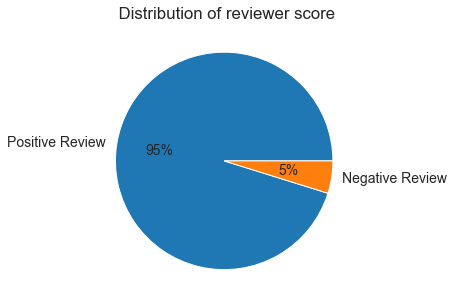

In [12]:
# show is_review_bad distribution
data = rev_df["is_review_bad"].value_counts(normalize = True)
#create pie chart
plt.pie(data, labels = ["Positive Review","Negative Review"], autopct='%.0f%%')
plt.title(" Distribution of reviewer score")
plt.show()

#### Since our dataset is highly imbalanced (only 5% is negative), this information is highly useful for modelling.



### 3.3 Distribution of Average Score by Hotel Name

<AxesSubplot:xlabel='Average_Score', ylabel='count'>

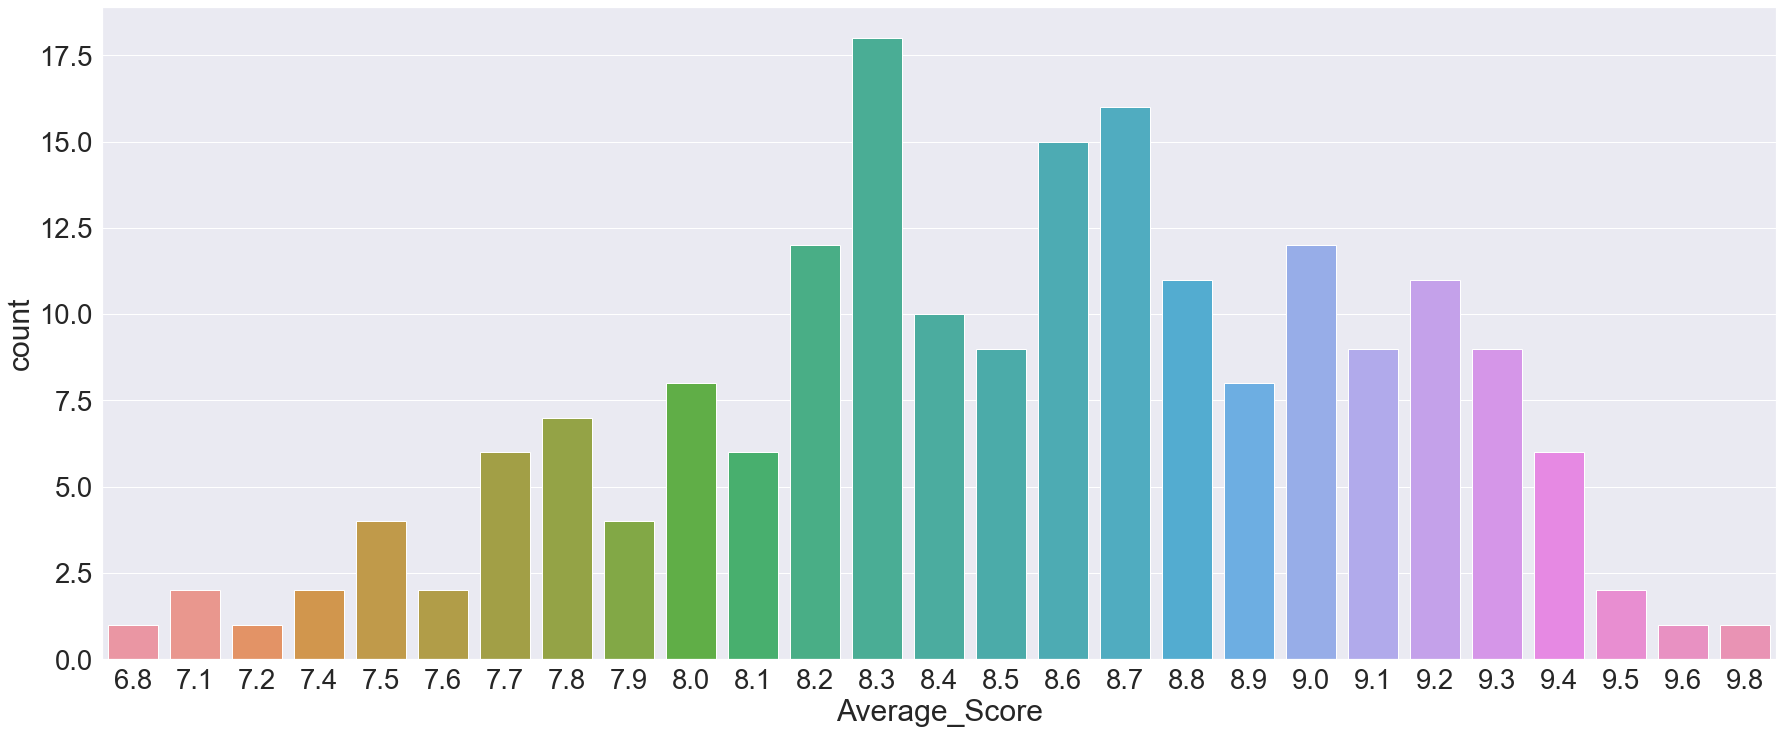

In [13]:
data_plot = rev_df[["Hotel_Name","Average_Score"]].drop_duplicates()
sns.set(font_scale = 2.5)
fig, ax = plt.subplots(figsize=(30, 12))
sns.countplot(ax = ax,x = "Average_Score",data=data_plot)

<b>We see that most of the Hotels average_score lie in the range of --8.0 and 9.1 --range.</b>

### 3.4 Count of reviews per nationality

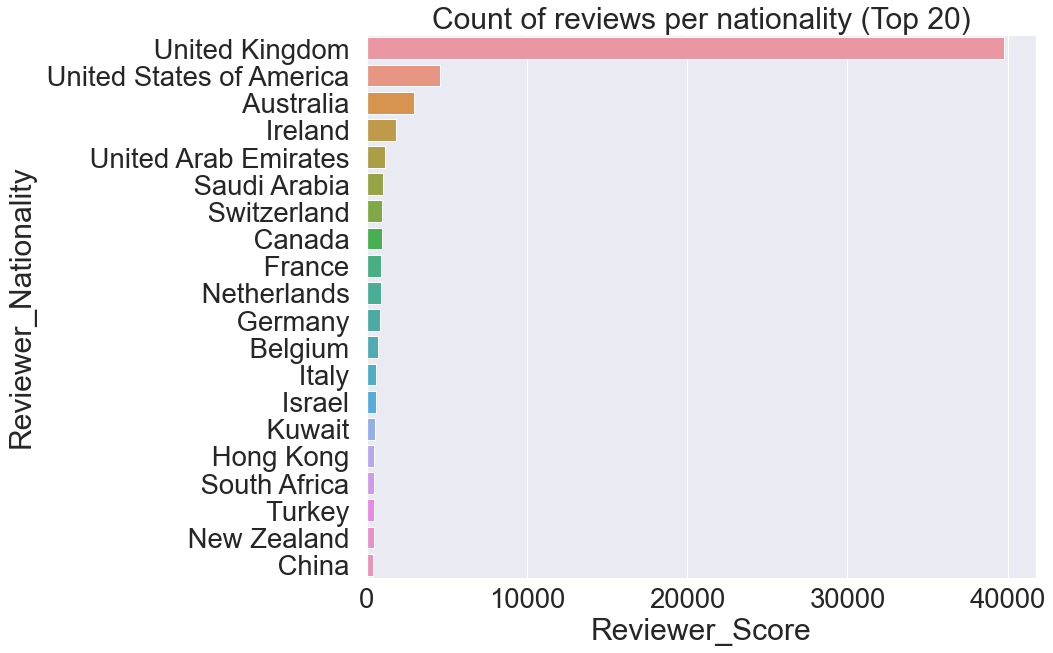

In [14]:
Nationalities = rev_df.groupby('Reviewer_Nationality')[['Reviewer_Score']].agg('count')
Nationalities = Nationalities.sort_values(by='Reviewer_Score', ascending=False).head(20).reset_index()


plt.figure(figsize=(12,10))
plt.title("Count of reviews per nationality (Top 20)")
sns.barplot(x='Reviewer_Score', y='Reviewer_Nationality', data=Nationalities);

### 3.5 Hotel Location on World Map

In [15]:
fig_ = px.density_mapbox(rev_df,lat='lat',lon='lng',radius=4, center=dict(lat=50,lon=27),zoom=2.9, mapbox_style='stamen-terrain')
fig_.show()

### 3.6 Review Sentiment Distribution 

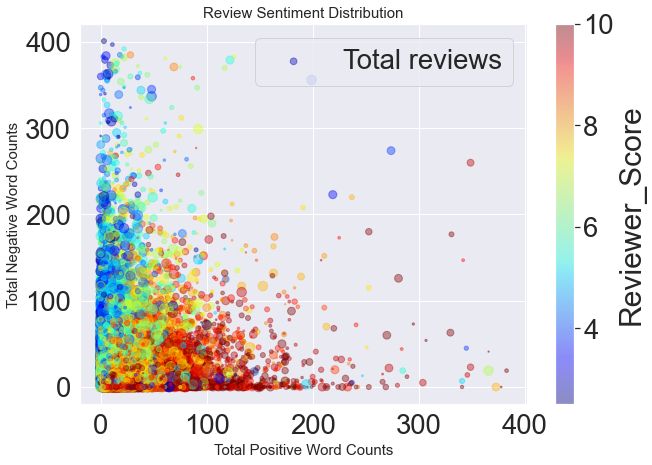

In [16]:
rev_df.plot( kind='scatter', x='Review_Total_Positive_Word_Counts', y='Review_Total_Negative_Word_Counts', label='Total reviews',
             s=rev_df.Total_Number_of_Reviews/100,c='Reviewer_Score',cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,7),sharex=False)
plt.title("Review Sentiment Distribution",  fontsize=15)
plt.xlabel("Total Positive Word Counts", fontsize=15)
plt.ylabel("Total Negative Word Counts",  fontsize=15)
plt.legend()
plt.show()

### 3.7 Wordcloud

In [17]:
# wordcloud function
def get_word_cloud(data, title = None):
        wcnt = WordCloud(
        background_color = 'white',
        max_words = 100,
        max_font_size = 38,
        stopwords=stopwords.words("english"),
        scale = 3,
        random_state = 49
    ).generate(str(data))
        fig = plt.figure(1, figsize = (18, 20))
        plt.axis('off')

        plt.imshow(wcnt, interpolation="bilinear")
        plt.show()

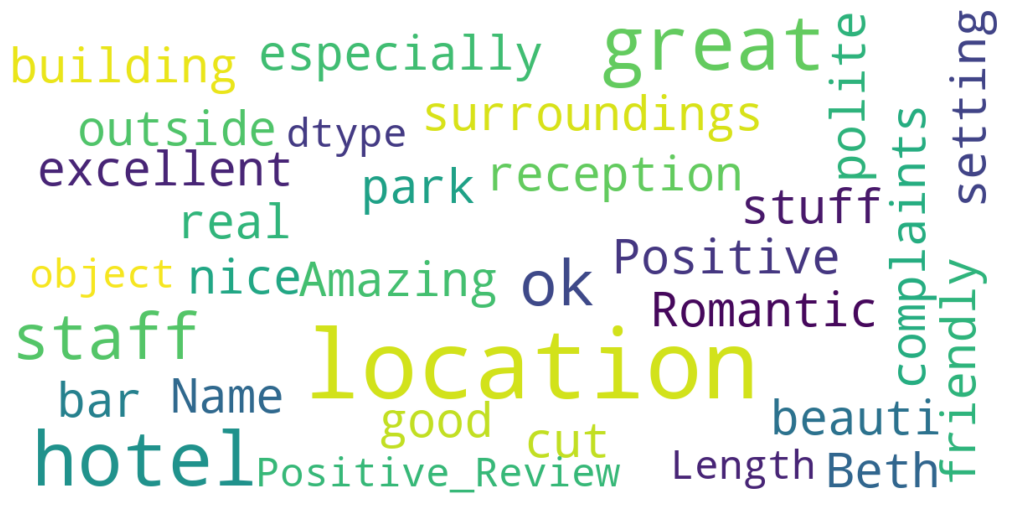

In [18]:
# print wordcloud
get_word_cloud(rev_df["Positive_Review"])

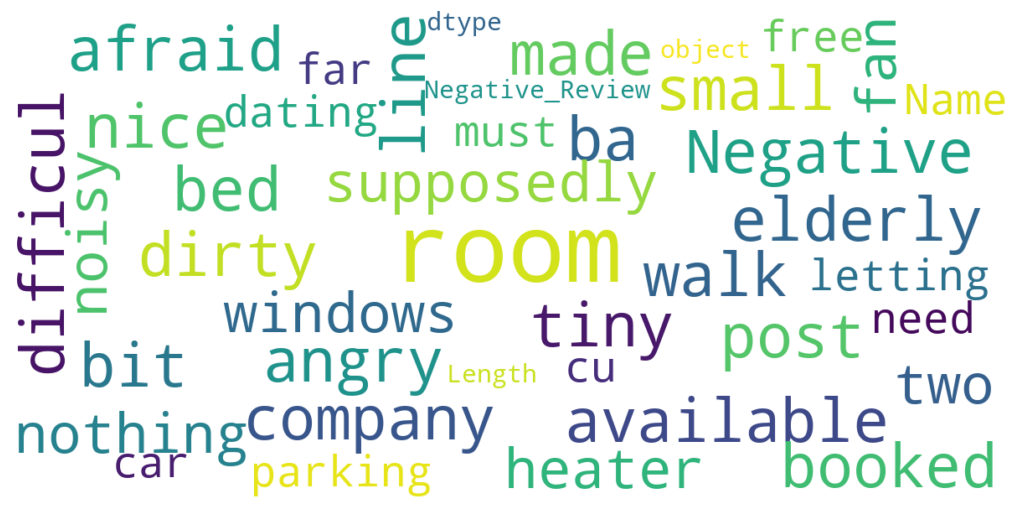

In [19]:
# print wordcloud
get_word_cloud(rev_df["Negative_Review"])

The majority of the words above are hotel-related -> room, breakfast, staff, and so on..

The remaining few are associated with the client experience -> pricey, appreciated, loved, and so on.

### 3.8 Highest positive sentiment reviews

In [20]:
# Reviews with the most positive sentiment--
rev_df[rev_df["nb_words"] >= 6].sort_values("pos", ascending = False)[["review", "pos"]].head(8)

review    pos
50106   Friendly helpful staff Clean super comfortable   0.941
43101        A perfect location comfortable great value  0.931
23856                 Excellent friendly helpful staff   0.907
55329             Clean comfortable excellent location   0.907
23756                          Lovely clean nice decor   0.903
4642                   Excellent helpful staff comfort   0.900
48534        Great location excellent staff super clean  0.878
44036    Perfect location Lovely friendly helpful staff  0.871

The most positive ones do correspond to the pleasant feedback. 

### 3.9 Lowest negative sentiment reviews

In [21]:
# Reviews with the fewest negative comments--
rev_df[rev_df["nb_words"] >= 6].sort_values("neg", ascending = False)[["review", "neg"]].head(8)


review    neg
55053          Nothing Comfortable safe amazing location  0.804
68429                    Poor breakfast Not warm welcome  0.784
22978          Nothing  Lovely comfortable surroundings   0.743
48935   Nothing Great location Great service Great co...  0.712
14506                              No complaints at all   0.710
60837   nothing Lovely environment great character gr...  0.707
60365        Horrible service dirty room and Rude staff   0.701
41115                 No airco defect Showen Head defect  0.700

### 3.10 Sentiment Distribution for positive and negative reviews

/Users/ankitaindi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/Users/ankitaindi/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).



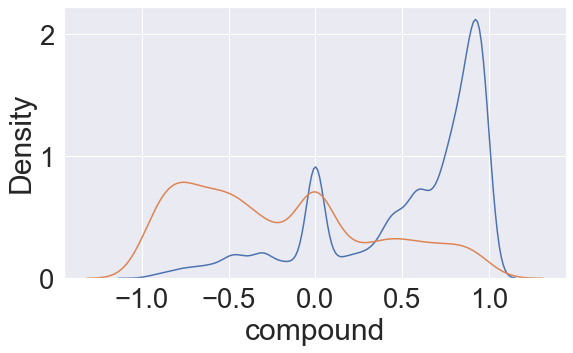

In [22]:
# Considering both good and negative reviews, plot the emotion distribution
for x_i in [0, 1]:
    subset = rev_df[rev_df['is_review_bad'] == x_i]
    
    # Draw the density plot
    if x_i == 0:
        label_ = "Good reviews"
    else:
        label_ = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label_)


The graph above depicts the distribution of positive and negative reviews sentiment. We can see that Vader thinks favorable reviews are a good thing. Furthermore, negative evaluations receive poor sentiment scores.

## 4. Modelling 

Modelling the dependant variable (is_review_bad)

In [23]:
# --feature selection
label = "is_review_bad"
ignore_cols = ["label", "review", "clean_review",'Additional_Number_of_Scoring','Average_Score','Hotel_Address','Hotel_Name','Negative_Review',
 'Positive_Review','Review_Date','Review_Total_Negative_Word_Counts','Review_Total_Positive_Word_Counts','Reviewer_Nationality','Reviewer_Score','Tags',
 'Total_Number_of_Reviews','Total_Number_of_Reviews_Reviewer_Has_Given','clean_review','days_since_review','is_review_bad','lat','lng']

features = [c_i  for c_i  in rev_df.columns if c_i not in ignore_cols]

### 4.1Test Train split

In [24]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(rev_df[features], rev_df[label], test_size = 0.26, random_state = 49)

For model trainnig, we choose which features to employ. The data was then divided into two portions -

 - first for model training
 - second for performance assessment

We implement a Random Forest-- classifier-- for our predictions.


### 4.2 Random Forest

In [25]:
# train a random forest classifier
rfrst = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfrst.fit(X_train, y_train)
y_pred =  rfrst.predict(X_test)
rfrst_acc=accuracy_score(y_test, y_pred)
# Display accuracy score
print("Accuracy : ",rfrst_acc)

Accuracy :  0.9563736263736263


### 4.3 Feature Importance

In [26]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rfrst.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(10)

feature  importance
3           compound    0.039088
2                pos    0.026373
6   doc2vec_vector_0    0.020441
0                neg    0.020150
10  doc2vec_vector_4    0.018618
9   doc2vec_vector_3    0.017217
8   doc2vec_vector_2    0.015241
4           nb_chars    0.015130
7   doc2vec_vector_1    0.014948
1                neu    0.014618

### 4.4 ROC Curve

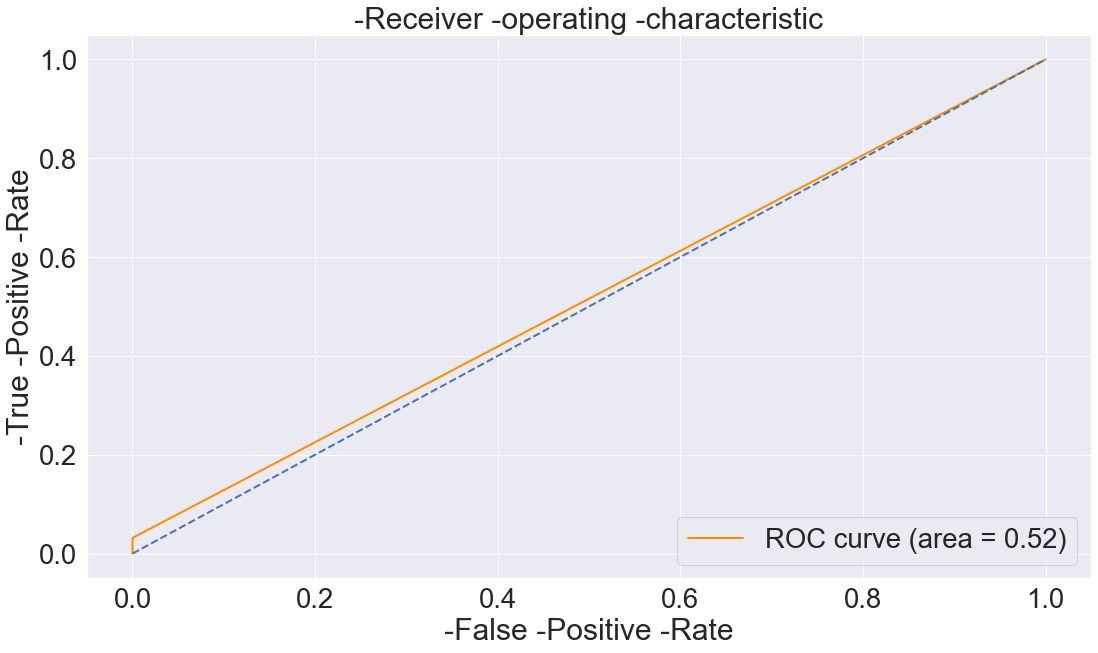

In [27]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

rocAuc_1 = auc(fpr, tpr)

plt.figure(1, figsize = (18, 10))
plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % rocAuc_1)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('-False -Positive -Rate')
plt.ylabel('-True -Positive -Rate')
plt.title('-Receiver -operating -characteristic')
plt.legend(loc="lower right")
plt.show()



The ROC curve is typically an honest graph to summarize the standard of our classifier. The higher the curve is on top of the diagonal baseline, the more good predictions we get. But AUC_ROC should not be only criteria to assess quality of model.

Our model will be able to predict a large number of false positives while maintaining a low false positive rate, increasing the true positive rate and therefore artificially improving the AUC ROC measure.

### 4.6 Logistic Regression

In [28]:
# train a logistic forest classifier
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=600)
lr.fit(X_train,y_train)
y_pred =  lr.predict(X_test)
lr_acc=accuracy_score(y_test, y_pred)
# Display accuracy score
print("Accuracy : ",lr_acc)

/Users/ankitaindi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy :  0.9584065934065934


### 4.6 XGBoost

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X=X_train,y=y_train)

y_pred=xgb_cl.predict(X_test)
xg_acc=accuracy_score(y_test, y_pred)
print("Accuracy : ",xg_acc)

### 4.7 Comparing Model Accuracy

In [ ]:
log=pd.DataFrame([["Random Forest",rfrst_acc],["Logistic Regression",lr_acc],["XGBoost",xg_acc]],columns=["Classifier", "Accuracy"])

sns.barplot(x='Accuracy', y='Classifier', data=log)

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

# Recommendation engine

In [ ]:
rev_df.Hotel_Address = rev_df.Hotel_Address.str.replace("United Kingdom", "UK")
# Now I will split the address and pick the last word in the address to identify the country
rev_df["countries"] = rev_df.Hotel_Address.apply(lambda x: x.split(' ')[-1])

In [ ]:

def impute(column):
    column = column[0]
    if (type(column) != list):
        return "".join(literal_eval(column))
    else:
        return column
    
rev_df["Tags"] = rev_df[["Tags"]].apply(impute, axis=1)

In [ ]:
def recommend_hotel(location, description):
    description = description.lower()
    word_tokenize(description)
    lemm = WordNetLemmatizer()
    filtered  = {word for word in description if not word in stopwords.words("english")}
    filtered_set = set()
    for fs in filtered:
        filtered_set.add(lemm.lemmatize(fs))

    cntry = rev_df[rev_df['countries']==location]
    cntry = cntry.set_index(np.arange(cntry.shape[0]))
    list1 = []; list2 = []; cos = [];
    for i in range(cntry.shape[0]):
        temp_token = word_tokenize(cntry["Tags"][i])
        temp_set = [word for word in temp_token if not word in stopwords.words("english")]
        temp2_set = set()
        for s in temp_set:
            temp2_set.add(lemm.lemmatize(s))
        vector = temp2_set.intersection(filtered_set)
        cos.append(len(vector))
    cntry['similarity']=cos
    cntry = cntry.sort_values(by='similarity', ascending=False)
    cntry.drop_duplicates(subset='Hotel_Name', keep='first', inplace=True)
    cntry.sort_values('Average_Score', ascending=False, inplace=True)
    cntry.reset_index(inplace=True)
    return cntry[["Hotel_Name", "Average_Score", "Hotel_Address"]].head(10)

In [ ]:
recommend_hotel('UK', 'Classic Double Room')

In [ ]:
recommend_hotel('UK', 'Children Room')

In [ ]:
recommend_hotel('UK', 'Buisness trip')

## 5. Conclusion


It is feasible to make predictions using simply raw text as input. Extracting meaningful features from this raw data is the most critical step. This is frequently a useful supplement to our data projects, allowing us to extract more learning features and improve the predictive power of our models.


## 6. References


https://towardsdatascience.com/a-complete-sentiment-analysis-project-using-pythons-scikit-learn-b9ccbb0405c2

https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe
